In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
df= pd.read_csv('/Users/markespina/Downloads/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013_13tbl8ny.csv')

In [3]:
def clean_dataset(data):
    data= data.iloc[4:]

    data.columns=['City', 'Population', 'Violent_crime',
       'Murder_manslaughter',
       'Rape_ver1', 'Rape_ver2',
       'Robbery', 'Aggravated_assault', 'Property_crime', 'Burglary',
       'Larceny_theft', 'auto_theft', 'Arson3']



    data= data.reset_index().drop('index', axis=1)

    data=data.iloc[:348]
    data.Arson3.fillna(0, inplace=True)


    data['City']=pd.Categorical(data.City).codes.reshape(-1,1)

    data["Population"]=data.Population.str.replace(',', "").astype(int)

    data['Population2']=data['Population']**2

    for col in ['Violent_crime', 'Murder_manslaughter','Rape_ver2', 'Robbery', 'Aggravated_assault', 'Property_crime'\
       , 'Burglary', 'Larceny_theft', 'auto_theft']:
        data[col]= data[col].str.replace(',',"").astype(int)

    features=data[['City','Population','Population2','Violent_crime', 'Murder_manslaughter','Rape_ver2', 'Robbery', 'Aggravated_assault', 'Property_crime'\
       , 'Burglary', 'Larceny_theft', 'auto_theft']]
    return features

In [4]:
df =clean_dataset(df)

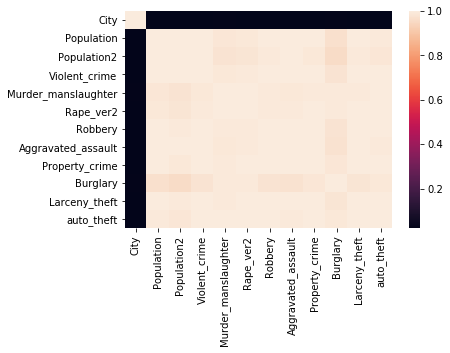

In [5]:
sns.heatmap(df.corr())

In [6]:
# starting data/features
X = df[['City','Population','Population2','Violent_crime', 'Murder_manslaughter']]
y = df['Property_crime']

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)

lr = LinearRegression()

# Reduce X to R(X) and regress on y.
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


0.731459166461456

In [24]:
# use Partial Least Squares to reduce dementionality
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)
pls1 = PLSRegression(n_components=3)

# R^2 increased by wide margin, since all variables are highly correlated, resulting increase in performance is expected
pls1.fit(X_train, y_train)
pls1.score(X_test, y_test)

0.9466020141483428

In [76]:
# manual grouping of features for pca
violent_crimes=['Violent_crime', 'Murder_manslaughter','Rape_ver2', 'Aggravated_assault']

thefts=['Burglary', 'Larceny_theft', 'auto_theft']
aggr_features=[[violent_crimes, 'violent_crime'], [thefts, 'theft']]

#reduce features
for group in aggr_features:
    means = df[group[0]].mean(axis=0)
    stds = df[group[0]].std(axis=0)
    df[group[1]]=((df[group[0]] - means) / stds).mean(axis=1)


In [77]:
#3 reduce to new components
X = df[['Population', 'Population2','violent_crime', 'theft']]
y=df['Property_crime']


In [78]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

lr.fit(X_train, y_train)

#R^2 for manually reduced data is fairly similar to what is achieved with Partial least squares
lr.score(X_test, y_test)

0.9652924829740417

[ 0.92407579 -0.31810449  0.1070072   0.95780046 -0.50173725  0.92219207
  0.9610564   0.62110638  0.82901192  0.98010325]


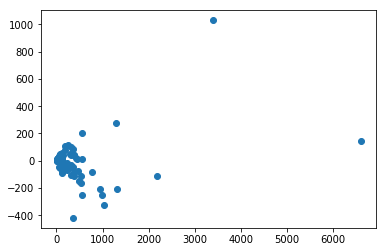

In [35]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(lr, X_test, y_test, cv=10))
y_pred = lr.predict(X_test)

plt.scatter(y_pred, y_pred-y_test)

In [38]:
cross_val_score(lr, X_test, y_test, cv=5)

array([0.92452118, 0.78562815, 0.94173713, 0.95588277, 0.96066149])

In [31]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)
pls12 = PLSRegression(n_components=3)

# Reduce X to R(X) and regress on y.
pls12.fit(X_train, y_train)
hold_out = pls12.score(X_test,y_test)
sample = pls12.score(X,y)
print('With 20% Holdout: ', hold_out)
print('Sample: ', sample)

With 20% Holdout:  0.9466020141483428
Sample:  0.999642873181724


In [356]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error 

In [357]:
y_pred = lr.predict(X_test)

In [232]:
mean_absolute_error(y_test,y_pred)

175.1299823183129

In [233]:
mean_squared_error(y_test, y_pred)

78944.21064199276

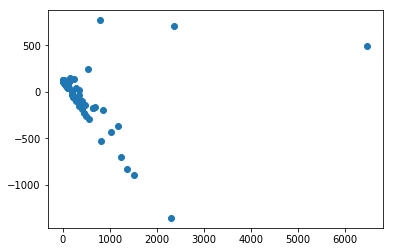

In [234]:
plt.scatter(y_test, y_pred-y_test)

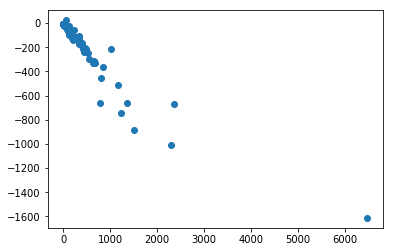

In [79]:
from sklearn import preprocessing

#standardize reduced features
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

y_pred = lr.predict(X_test_transformed)

plt.scatter(y_test, y_pred-y_test)

In [81]:
cross_val_score(lr, X_test_transformed, y_test, cv=10)

array([ 0.92407579, -0.31810449,  0.1070072 ,  0.95780046, -0.50173725,
        0.92219207,  0.9610564 ,  0.62110638,  0.82901192,  0.98010325])

In [90]:
lr = LinearRegression()
lr.fit(X_train_transformed, y_train)
lr.score(X_test_transformed, y_test)

0.9652924829777443

In [91]:
def adj_r2(X, y, r2):
    return 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)

lr = LinearRegression()

lr.fit(X_train_transformed, y_train)

adj_r2(X_test_transformed, y_test, lr.score(X_test_transformed, y_test))

0.9635994333669026

In [89]:
lr = LinearRegression()
lr.fit(X_train_transformed, y_train)
lr.score(X_test_transformed, y_test)

0.9652924829777443

In [45]:
#cross validation remains unchanged despite standardizing X
cross_val_score(lr, X_test_transformed, y_test, cv=10)

array([ 0.92407579, -0.31810449,  0.1070072 ,  0.95780046, -0.50173725,
        0.92219207,  0.9610564 ,  0.62110638,  0.82901192,  0.98010325])

In [92]:
#try a new dataset
new_df= pd.read_excel('/Users/markespina/Downloads/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls')

In [93]:
def clean_dataset2(data):
    
    data.columns= list(data.iloc[3])
    data= data.iloc[4:]

    data.columns=['City', 'Population', 'Violent_crime',
       'Murder_manslaughter',
       'Rape_ver1', 'Rape_ver2',
       'Robbery', 'Aggravated_assault', 'Property_crime', 'Burglary',
       'Larceny_theft', 'auto_theft', 'Arson3']



    data= data.reset_index().drop('index', axis=1)

    data=data[:348]
    data.Arson3.fillna(0, inplace=True)

    data.head()
    
    data['City']=pd.Categorical(data.City).codes.reshape(-1,1)

    #data["Population"]=data.Population.str.replace(',', "").astype(int)

    data['Population2']=data['Population']**2
    
    data['Rape_ver1'].fillna(method='backfill', axis=0, inplace=True)


    features=data[['City','Population','Population2','Violent_crime', 'Murder_manslaughter','Rape_ver1', 'Robbery', 'Aggravated_assault', 'Property_crime'\
       , 'Burglary', 'Larceny_theft', 'auto_theft']]
    return features

In [94]:
clean_dataset2(new_df)

,City,Population,Population2,Violent_crime,Murder_manslaughter,Rape_ver1,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny_theft,auto_theft
0,0,1851,3426201,0,0,0,0,0,11,1,10,0
1,1,2568,6594624,2,0,0,1,1,49,1,47,1
2,2,820,672400,0,0,0,0,0,1,0,1,0
3,3,2842,8076964,1,0,54,0,1,17,0,17,0
4,4,98595,9720974025,802,8,54,237,503,3888,683,3083,122
5,5,5872,34480384,26,0,3,2,21,204,41,159,4
6,6,1107,1225449,0,0,0,0,0,7,2,5,0
7,7,4032,16257024,11,1,1,0,9,30,6,24,0
8,8,1723,2968729,1,0,0,0,1,2,2,0,0
9,9,118860,14127699600,128,1,16,43,68,2066,176,1846,44


In [95]:
new_df = clean_dataset2(new_df)

In [96]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
City                   348 non-null int16
Population             348 non-null object
Population2            348 non-null object
Violent_crime          348 non-null object
Murder_manslaughter    348 non-null object
Rape_ver1              348 non-null int64
Robbery                348 non-null object
Aggravated_assault     348 non-null object
Property_crime         348 non-null object
Burglary               348 non-null object
Larceny_theft          348 non-null object
auto_theft             348 non-null object
dtypes: int16(1), int64(1), object(10)
memory usage: 30.7+ KB


In [97]:
new_df=pd.DataFrame(new_df.values)
new_df.columns = ['City', 'Population', 'Population2', 'Violent_crime',
       'Murder_manslaughter', 'Rape_ver2', 'Robbery', 'Aggravated_assault',
       'Property_crime', 'Burglary', 'Larceny_theft', 'auto_theft']

In [98]:
new_df.fillna(0, inplace=True)

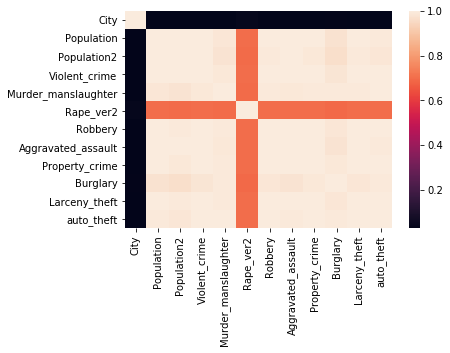

In [99]:
import seaborn as sns
#majority of variables are highly correlated
sns.heatmap(new_df.corr())

In [103]:
new_df['Population2']=new_df.Population**2
X = new_df[['Population', 'Population2','Murder_manslaughter', 'Burglary']]
y= new_df['Property_crime']

In [106]:
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y)
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.9770234802002591

In [107]:
cross_val_score(lr, X_test, y_test, cv=10)

array([-0.15684788,  0.02139889,  0.95933578,  0.57432089,  0.88763038,
        0.91172849,  0.35592215,  0.24507913,  0.4979362 ,  0.9096079 ])

In [108]:
# manual grouping of features for pca
violent_crimes=['Violent_crime', 'Murder_manslaughter','Rape_ver2', 'Aggravated_assault']

thefts=['Burglary', 'Larceny_theft', 'auto_theft']
aggr_features=[[violent_crimes, 'violent_crime'], [thefts, 'theft']]

#reduce features
for group in aggr_features:
    means = new_df[group[0]].mean(axis=0)
    stds = new_df[group[0]].std(axis=0)
    new_df[group[1]]=((new_df[group[0]] - means) / stds).mean(axis=1)

In [118]:
X = new_df[['Population','Population2', 'violent_crime', 'theft']]
y=new_df['Property_crime']


In [119]:
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y)
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.9919031313246237

In [120]:
cross_val_score(lr,X_test, y_test, cv=10)

array([0.64857064, 0.99517198, 0.91290748, 0.73826657, 0.97909424,
       0.9782363 , 0.97027396, 0.6913195 , 0.86315272, 0.79304863])

In [121]:
from sklearn.linear_model import BayesianRidge


In [72]:
# try different model
br= BayesianRidge()
br.fit(X_train,y_train)
br.score(X_test, y_test)

0.6097717170509844

In [123]:
from sklearn.cross_decomposition import PLSRegression

plsr = PLSRegression(n_components=3)
plsr.fit(X_train,y_train)
plsr.score(X_test,y_test)

0.9884293694193169

In [124]:
cross_val_score(plsr, X_test, y_test, cv=15)

array([ 0.88375904, -1.14512024,  0.98251303, -0.90472209,  0.90099203,
        0.83729049,  0.98473255,  0.80605153,  0.97097827,  0.97706124,
        0.79968823,  0.58162224,  0.78056066,  0.77994044,  0.88264892])

In [125]:
print('With 20% Holdout: ' + str(plsr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(plsr.fit(X, y).score(X, y)))

With 20% Holdout: 0.9884293694193169
Testing on Sample: 0.9996504821622333
